# Results Markov

In [1]:
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())
import math
import copy
import gc

import src.ml.markov as mk
from src.dao.experiments_dao import load_execution_test_data_by_model

from src.exceptions import exceptions

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt

working dir /home/tales/dev/master/mdc_analysis


## Loading data

In [2]:
def round_up_list(num_list):
    rounded = [math.ceil(i) for i in num_list]
    return rounded

def hits_contain(df):
    df = copy.deepcopy(df)
    df["hits_contain"] = df["partial_hits"].apply(lambda lista : round_up_list(lista))
    df["hits_contain_mean"] = df["partial_hits"].apply(lambda lista : pd.Series(round_up_list(lista)).mean())
    return df

def json_to_dataframe(json_list, simple_cols=True):
    df = pd.DataFrame(json_list)
    
    df["iteration"] = df["iteration"].astype(str)
    df["k"] = df["k"].astype(str)
    
    df["acc"] = df["total_hits"] / df["test_size"]
    
    df["partial_hits_mean"] = df["partial_hits"].apply(lambda lista : pd.Series(lista).mean())
    
    df_markov = df[df["algorithm"] == "markov"]
    df_rest = df[df["algorithm"] != "markov"]
    
    df_markov = hits_contain(df_markov)
    
    df = df_markov.append(df_rest)
    
    df_markov = None
    df_rest = None
    
    gc.collect()
    
    if simple_cols:
        del df["states_not_trained_as_origin"]
        del df["hits"]
        del df["misses"]
        
    return df

In [3]:
results_dir = "single_partition"

mk_results = load_execution_test_data_by_model(results_dir)
print("{} tests".format(len(mk_results)))

r = json_to_dataframe(mk_results, simple_cols=False)

r_dummy = r[r["is_dummy"] == True]
r = r[r["is_dummy"] == False]

r.sample(4)

1872 tests


acc algorithm  depth  \
296  0.208       ctw  2.000   
1846 0.091       ctw  2.000   
93   0.235    markov    nan   
1387 0.619    markov    nan   

                                                   hits  \
296   [NoCategoryMatched, NoCategoryMatched, NoCateg...   
1846  [health, health, health, health, health, HOME,...   
93    [['store'], ['HOME'], ['WORK'], ['HOME'], ['st...   
1387  [['health'], ['hair_care'], ['cafe'], ['store'...   

                                           hits_contain  hits_contain_mean  \
296                                                 NaN                nan   
1846                                                NaN                nan   
93    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, ...              0.236   
1387  [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, ...              0.650   

     input_data_version  is_distributive  is_dummy iteration   ...     \
296        0.0.categ_v1            False     False         2   ...      
1846       0.0.categ_v1            False     False         1   ...      
93         0.0.categ_v1            False     False         0   ...      
1387       0.0.categ_v1            False     False         0   ...      

     predict_choice_method states_not_trained_as_origin  \
296            most_likely                          NaN   
1846         random_choice                          NaN   
93                     NaN                           []   
1387                   NaN                           []   

                                   test_id test_size  total_hits total_misses  \
296   018c843b-a734-44fc-a88f-65d5db40e967        48          10           36   
1846  7ab8aee9-4d2d-4ab0-9aca-2a0ffbbd0a6a       493          45          446   
93    9a1df033-b17a-4fc9-be1b-e85150a34ac5       663         156          506   
1387  69a51883-c8f7-4eda-9588-972e1bc1e9db        21          13            7   

     total_states_not_trained_as_origin train_size trained_with  user_id  
296                                 nan         48    same_user     6002  
1846                                nan        493    same_user     6188  
93                                0.000        663    same_user     5966  
1387                              0.000         21    same_user     6064  

[4 rows x 26 columns]

## Summary

In [4]:
r["input_data_version"].value_counts()

0.0.categ_v1    1404
Name: input_data_version, dtype: int64

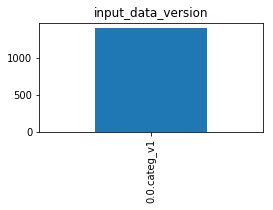

In [5]:
r["input_data_version"].value_counts().plot.bar(title="input_data_version", figsize=(4,2))

In [6]:
r["method"].value_counts()

single_partition    1404
Name: method, dtype: int64

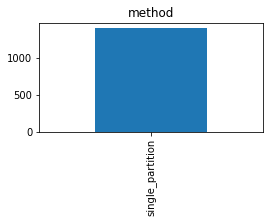

In [7]:
r["method"].value_counts().plot.bar(title="method", figsize=(4,2))

In [8]:
r["algorithm"].value_counts()

ctw       936
markov    468
Name: algorithm, dtype: int64

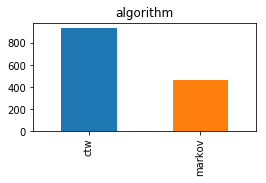

In [9]:
r["algorithm"].value_counts().plot.bar(title="algorithm", figsize=(4,2))

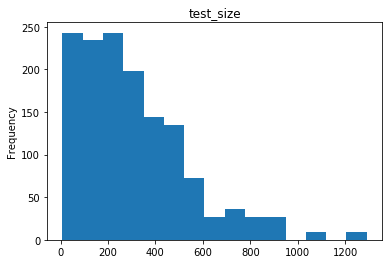

In [10]:
r["test_size"].plot.hist(title="test_size", bins=15)

## Accuracy

In [11]:
# def markov_accuracy(results):
#     return results["total_hits"].sum() / (results["total_hits"].sum() + results["total_misses"].sum())

def print_results(use_results):
    algorithm = use_results["algorithm"].drop_duplicates().item()
    print("algorithm: {}".format(algorithm))
    method = use_results["method"].drop_duplicates().item()
    print("method: {}".format(method))
    print()
    acc = use_results["acc"].median()
    print("    Accuracy: {0:.4f}".format(acc))
    mad = use_results["acc"].mad()
    print("    Mean Absolute Deviation: {0:.4f}".format(mad))
    print("    ---")
    p_acc = use_results["partial_hits_mean"].median()
    print("    Partial Hits Mean: {0:.4f}".format(p_acc))
    p_mad = use_results["partial_hits_mean"].mad()
    print("    Mean Absolute Deviation: {0:.4f}".format(p_mad))
    print("    ---")
    contain_acc = use_results["hits_contain_mean"].mean()
    print("    Contains Partial Hits Mean: {0:.4f}".format(contain_acc))
    print("    ---")
    print()
    input_data_version = use_results["input_data_version"].drop_duplicates().item()
    return {"algorithm": algorithm, "method": method, "acc": acc, "partial_acc": p_acc, "mad": mad, "partial_mad": p_mad, "input_data": input_data_version, "contains_acc": contain_acc}


In [12]:
results = []

### markov-0.0

In [13]:
hist_plot = []

use_data = r[(r["algorithm"] == "markov") & (r["input_data_version"] == "0.0")]

for method in use_data["method"].drop_duplicates().sort_values():
    use_results = use_data[use_data["method"] == method]
    result_row = print_results(use_results)
    results.append(result_row)

### markov-0.0.d

In [14]:
hist_plot = []

use_data = r[(r["algorithm"] == "markov") & (r["input_data_version"] == "0.0.d")]

for method in use_data["method"].drop_duplicates().sort_values():
    use_results = use_data[use_data["method"] == method]
    result_row = print_results(use_results)
    results.append(result_row)

### markov-0.0.categ_v1

In [15]:
hist_plot = []

use_data = r[(r["algorithm"] == "markov") & (r["input_data_version"] == "0.0.categ_v1")]

for method in use_data["method"].drop_duplicates().sort_values():
    use_results = use_data[use_data["method"] == method]
    result_row = print_results(use_results)
    results.append(result_row)

algorithm: markov
method: single_partition

    Accuracy: 0.2580
    Mean Absolute Deviation: 0.0880
    ---
    Partial Hits Mean: 0.2608
    Mean Absolute Deviation: 0.0917
    ---
    Contains Partial Hits Mean: 0.2910
    ---



In [16]:
hist_plot = []

use_data = r[(r["algorithm"] == "ctw") & (r["input_data_version"] == "0.0.categ_v1")]

for method in use_data["method"].drop_duplicates().sort_values():
    use_results = use_data[use_data["method"] == method]
    result_row = print_results(use_results)
    results.append(result_row)

algorithm: ctw
method: single_partition

    Accuracy: 0.1637
    Mean Absolute Deviation: 0.0830
    ---
    Partial Hits Mean: nan
    Mean Absolute Deviation: nan
    ---
    Contains Partial Hits Mean: nan
    ---



### Filling Data Frame with dummy results

In [17]:
# dummy_data = r[r["input_data_version"].str.endswith("DUMMY")]

# for method in dummy_data["method"].drop_duplicates().sort_values():
#     for input_data_version in dummy_data["input_data_version"].drop_duplicates():
#         use_results = dummy_data[(dummy_data["method"] == method) & (dummy_data["input_data_version"] == input_data_version)]
#         result_row = print_results(use_results)
#         results.append(result_row)

In [18]:
results_df = pd.DataFrame(results)
results_df

acc algorithm  contains_acc    input_data   mad            method  \
0 0.258    markov         0.291  0.0.categ_v1 0.088  single_partition   
1 0.164       ctw           nan  0.0.categ_v1 0.083  single_partition   

   partial_acc  partial_mad  
0        0.261        0.092  
1          nan          nan

# Complete matching <font color="red">accuracy</font>

### by Method

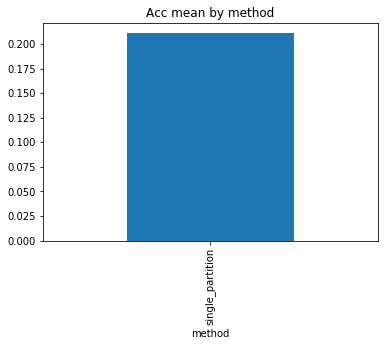

In [19]:
results_df.set_index("method").groupby("method").apply(lambda value : value.mean())["acc"].plot.bar(title="Acc mean by method")

### by Input Data

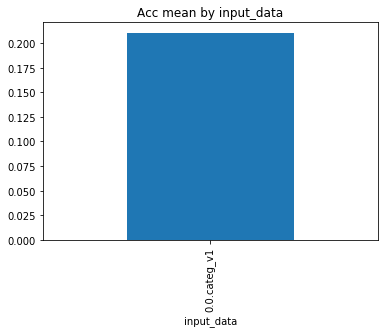

In [20]:
results_df.set_index("input_data").groupby("input_data").apply(lambda value : value.mean())["acc"].plot.bar(title="Acc mean by input_data")

# Comparing Input Data Version

# <font color="red">all_users_vs_one</font>

### Complete Array Matching

In [21]:
results_df[results_df["method"] == "all_users_vs_one"].set_index("input_data").groupby("input_data").apply(lambda value : value.mean())["acc"].plot.bar(title="Acc mean by method - Complete Array Matching")

KeyError: 'acc'

### Partial Array Matching (Jaccard)

In [ ]:
results_df[results_df["method"] == "all_users_vs_one"].set_index("input_data").groupby("input_data").apply(lambda value : value.mean())["partial_acc"].plot.bar(title="Acc mean by method - Partial Array Matching")

The input data <b>markov-0.0.categ_v1</b> is insensitive for <b>Partial Matching</b> since it has only one category as tag.

### Real Array Type <font color="red">Contains</font> Any Predicted Type
<b>Real:</b> [X,A,Z], <b>Pred:</b> [A, B] <BR>
<b>Real:</b> [C], <b>Pred:</b> [A,B,C]

In [ ]:
results_df[results_df["method"] == "all_users_vs_one"].set_index("input_data").groupby("input_data").apply(lambda value : value.mean())["contains_acc"].plot.bar(title="Acc mean by method - Array Contains Any Type")

The input data <b>markov-0.0.categ_v1</b> is insensitive for <b>Partial Matching</b> since it has only one category as tag.

# <font color="red">k_fold</font>

### <font color="red">Complete</font> Array Matching

In [ ]:
results_df[results_df["method"] == "k_fold"].set_index("input_data").groupby("input_data").apply(lambda value : value.mean())["acc"].plot.bar(title="Acc mean by method - Complete Array Matching")

### <font color="red">Partial</font> Array Matching (Jaccard)

In [ ]:
results_df[results_df["method"] == "k_fold"].set_index("input_data").groupby("input_data").apply(lambda value : value.mean())["partial_acc"].plot.bar(title="Acc mean by method - Partial Array Matching")

The input data <b>markov-0.0.categ_v1</b> is insensitive for <b>Partial Matching</b> since it has only one category as tag.

### Real Array Type <font color="red">Contains</font> Any Predicted Type
<b>Real:</b> [X,A,Z], <b>Pred:</b> [A, B] <BR>
<b>Real:</b> [C], <b>Pred:</b> [A,B,C]

In [ ]:
results_df[results_df["method"] == "k_fold"].set_index("input_data").groupby("input_data").apply(lambda value : value.mean())["contains_acc"].plot.bar(title="Acc mean by method - Array Contains Any Type")

The input data <b>markov-0.0.categ_v1</b> is insensitive for <b>Partial Matching</b> since it has only one category as tag.

# Comparing Algorithms

## algorithms

In [ ]:
results_df.set_index("algorithm").groupby("algorithm").apply(lambda value : value.mean())["acc"].plot.bar(title="Acc mean - Complete Array Matching")

## algorithms <font color="red">&</font> input_data_version

In [ ]:
results_df.set_index(["algorithm", "input_data"]).groupby(["algorithm", "input_data"]).apply(lambda value : value.mean())["acc"].sort_values().plot.bar(title="Acc mean - Complete Array Matching")

## algorithms <font color="red">&</font> input_data_version <font color="red">&</font> method

In [ ]:
f, ax = plt.subplots(figsize=(12,5))
results_df.set_index(["algorithm", "input_data", "method"], drop=False).groupby(["algorithm", "input_data", "method"])["acc"].mean().sort_values().plot.bar(title="Acc mean - Complete Array Matching")

## Comparing CTW depths

In [ ]:
r[r["algorithm"] == "ctw"].set_index(["method", "depth"]).groupby(["method", "depth"]).apply(lambda value : value.mean())["acc"].plot.bar(title="Acc mean - Complete Array Matching")

In [ ]:
pd.__version__